<a href="https://colab.research.google.com/github/MicheleGiambelli/PlotTwisters-Project/blob/main/Pulizia%20dati%20%2B%20DEA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import pandas as pd
import numpy as np
import spacy
import string
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
import plotly.express as px
import networkx as nx
from PIL import Image
import random
from itertools import combinations
from scipy.interpolate import make_interp_spline
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from numpy.random import seed

import torch

!pip install transformers datasets evaluate
!pip install transformers datasets evaluate seqeval

import os
import warnings
warnings.filterwarnings('ignore')

# Librerie di transformers e datasets
from transformers import AutoTokenizer, AutoModelForTokenClassification, Trainer, TrainingArguments, DataCollatorForTokenClassification
from datasets import Dataset, DatasetDict
import evaluate
from sklearn.model_selection import train_test_split

In [10]:
df1 = pd.read_csv('sample_data/file5.txt', header=None, delimiter='\t', names=['token', 'ner_tag'])

df2 = pd.read_csv('sample_data/file6.txt', header=None, delimiter='\t', names=['token', 'ner_tag'], skip_blank_lines=False)
df2["token"] = df2["token"].fillna("end")
df2["ner_tag"] = df2["ner_tag"].fillna("end")

#Assegna id di frase a file5
def is_sentence_end(token):
    return token.startswith('http://')

sentence_id = 0
for idx, row in df.iterrows():
    df.loc[idx, 'id'] = sentence_id
    if is_sentence_end(str(row['token'])):
        sentence_id += 1


#Assegna id di frase a file6
for idx, row in df2.iterrows():
  df2.loc[idx, 'id'] = sentence_id
  if row['token'] == 'end' and row["ner_tag"]=="end":
    sentence_id += 1

df2 = df2[df2["ner_tag"] != "end"]



combined_df = pd.concat([df, df2], ignore_index=True)

# Convertire la colonna id da float a int
combined_df['id'] = combined_df['id'].astype(int)

# Verifico corretta unione
print(f"Dimensioni di file5: {df1.shape}")
print(f"Dimensioni di file6: {df2.shape}")
print(f"Dimensioni del dataset combinato: {combined_df.shape}")
print("Etichette uniche nel dataset combinato:")
print(combined_df['ner_tag'].unique())

# Info
print("Informazioni sul DataFrame combinato:")
print(combined_df.info())

combined_df = combined_df.dropna(subset=['token']).reset_index(drop=True) # con questo medodo possiamo rimuovere le righe del dataframe il cui valore è mancante
print("Informazioni sul DataFrame dopo la rimozione dei NaN:")
print(combined_df.info())


# Verifichiamo la presenza di righe vuote (serve più avanti per un problema al codice altrimenti)
invalid_tokens = combined_df[~combined_df['token'].apply(lambda x: isinstance(x, str))]
print("Righe con valori non stringa nella colonna 'token':")
print(invalid_tokens)

# Eliminare le righe con valori non stringa nella colonna 'token'
combined_df = combined_df[combined_df['token'].apply(lambda x: isinstance(x, str))].reset_index(drop=True)


# **Pulizia del dataset**

Questo codice ha lo scopo di pulire il dataset rimuovendo *stopwords* (presenti nella libreria di spicy)e *punteggiatura* dai token in ciascun set di dati (train, validation e test). L'unica eccezione è il carattere @, che ho deciso di mantenere, poiché è significativo nei tweet e di solito precede nomi utente, indicando menzioni.

La punteggiatura rimossa è quella presente in

> set(string.punctuation)

ad eccezione del carattere @.

I caratteri di punteggiatura rimossi sono i seguenti:

!"#$%&'()*+,-./:;<=>?[\]^_`{|}~


In [31]:
# Caricare il modello di lingua inglese
nlp = spacy.load('en_core_web_sm')
stopwords = nlp.Defaults.stop_words
# Punteggiatura da rimuovere
punctuation = set(string.punctuation) - {'@'}

# Funzione per eliminare stopwords e punteggiatura
def remove_stopwords_and_punctuation(df):
    df['token_cleaned'] = df['token'].apply(lambda x: x if x.lower() not in stopwords and x not in punctuation else '')
    df = df[df['token_cleaned'] != '']  # Rimuove le righe con token vuoti
    return df.drop(columns=['token']).rename(columns={'token_cleaned': 'token'})  # Sostituisce token con token_cleaned

# Applicare la funzione ai tre dataset
combined_df = remove_stopwords_and_punctuation(combined_df)

print(f"Dimensioni del set di combined_df: {combined_df.shape}")

# Converti tutte le parole nella colonna 'token' in minuscolo
combined_df['token'] = combined_df['token'].str.lower()

print(combined_df.head(50))


Dimensioni del set di combined_df: (28709, 3)


In [40]:
import pandas as pd
from sklearn.model_selection import train_test_split
from numpy.random import seed

# Passo 1: Ottieni gli id unici delle frasi
unique_ids = combined_df['id'].unique()

# Passo 2: Mescola casualmente gli id
seed(42)  # Per rendere i risultati riproducibili
shuffled_ids = pd.Series(unique_ids).sample(frac=1, random_state=42).values

# Passo 3: Dividi gli id in training, validation e test
train_ids, temp_ids = train_test_split(shuffled_ids, test_size=0.3, random_state=42)  # 70% train, 30% resto
val_ids, test_ids = train_test_split(temp_ids, test_size=1/3, random_state=42)        # 2/3 validation, 1/3 test

# Passo 4: Filtra il dataset per ciascun set
train_df = combined_df[combined_df['id'].isin(train_ids)]
val_df = combined_df[combined_df['id'].isin(val_ids)]
test_df = combined_df[combined_df['id'].isin(test_ids)]

# Mostra il numero di righe in ciascun dataset
print(f"Train set: {len(train_df)} righe")
print(f"Validation set: {len(val_df)} righe")
print(f"Test set: {len(test_df)} righe")


Train set: 22137 righe
Validation set: 3958 righe
Test set: 2614 righe


In [42]:
print(train_df.head(35))

   ner_tag  id                    token
0        O   0                 Millions
2        O   0               family-run
3        O   0                   #farms
4        O   0                     hold
6        O   0                      key
8        O   0                   global
9        O   0                  #hunger
10       O   0                  reveals
11   B-ORG   0                      #UN
12       O   0                   report
14       O   0   http://t.co/9JKaxcMKJ0
15       O   1                   Cousin
17   B-PER   1                    Reeva
18   I-PER   1                Steenkamp
19       O   1                     says
20   B-PER   1               #Pistorius
22       O   1                      pay
29       O   1   http://t.co/7gSdzwFjJ6
30       O   2                    ICYMI
32   B-ORG   2                        @
33   B-ORG   2                 4corners
38   B-ORG   2                        @
39   B-ORG   2                flipboard
40       O   2                 magazine


**Mappatura dei tag NER a categorie semplificate**

Di seguito abbiamo deciso di raggruppare sotto una sola etichetta (LOC, PER, ORG, O) i tag dettagliati (B-LOC, I-LOC, ecc).

L'obiettivo è di rendere i tag NER più interbretabili per l'analisi successiva e facilitare la visualizzazione dei dati senza perdere informazioni importanti.

In [44]:
# Mappatura
mapping = {
    'B-LOC': 'LOC',
    'I-LOC': 'LOC',
    'B-PER': 'PER',
    'I-PER': 'PER',
    'B-ORG': 'ORG',
    'I-ORG': 'ORG',
    'O': 'O'
}

# Creazione della nuova colonna 'Label' nel training set
combined_df['Label'] = combined_df['ner_tag'].map(mapping)

# **Analisi esplorativa dei dati**

1. Distribuzione dei tag NER
Con questo codice volevamo capire la frequenza di ciascuna etichetta (O, PER, ORG, LOC) per vedere come sono distribuite le diverse entità nel dataset.

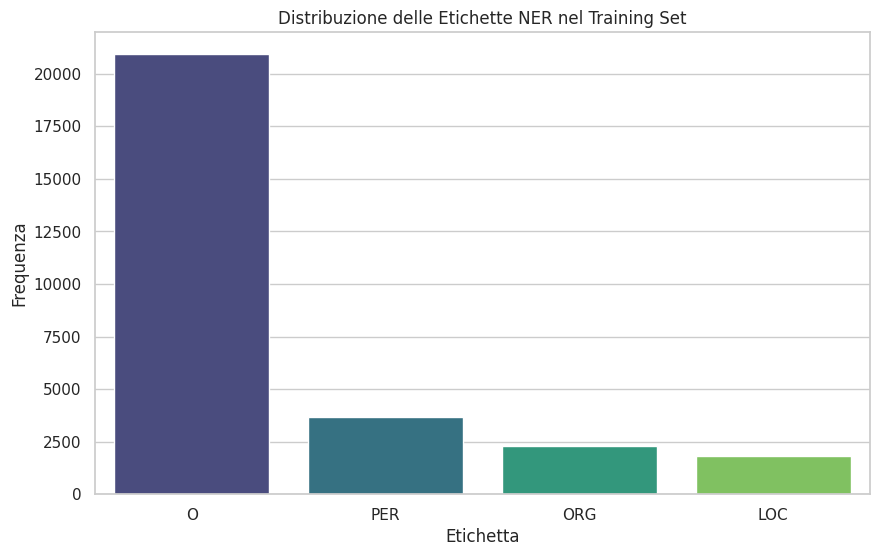

In [45]:
# Contiamo la frequenza di ciascuna etichetta nel training set
label_counts = combined_df['Label'].value_counts()

# Impostiamo lo stile di Seaborn
sns.set(style="whitegrid") # aggiungiamo riga grigia di sfondo

# Creiamo un grafico a barre
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis") # viridis sarebbe una palet di colori chiari


plt.title('Distribuzione delle Etichette NER nel Training Set')
plt.xlabel('Etichetta')
plt.ylabel('Frequenza')

plt.show()



---



2. **Entità di token più  frequenti per categoria**

Questo codice ha l'obiettivo di identificare le entità più frequenti per ciascuna categoria di etichetta NER (LOC, PER, ORG, O) nel training set, e visualizzare queste entità con un grafico a barre suddiviso in quadranti per ogni categoria.

Questo tipo di analisi permette di comprendere quali parole appaiono più frequentemente come entità in ogni categoria, fornendo insight sulla distribuzione dei termini più rappresentativi.

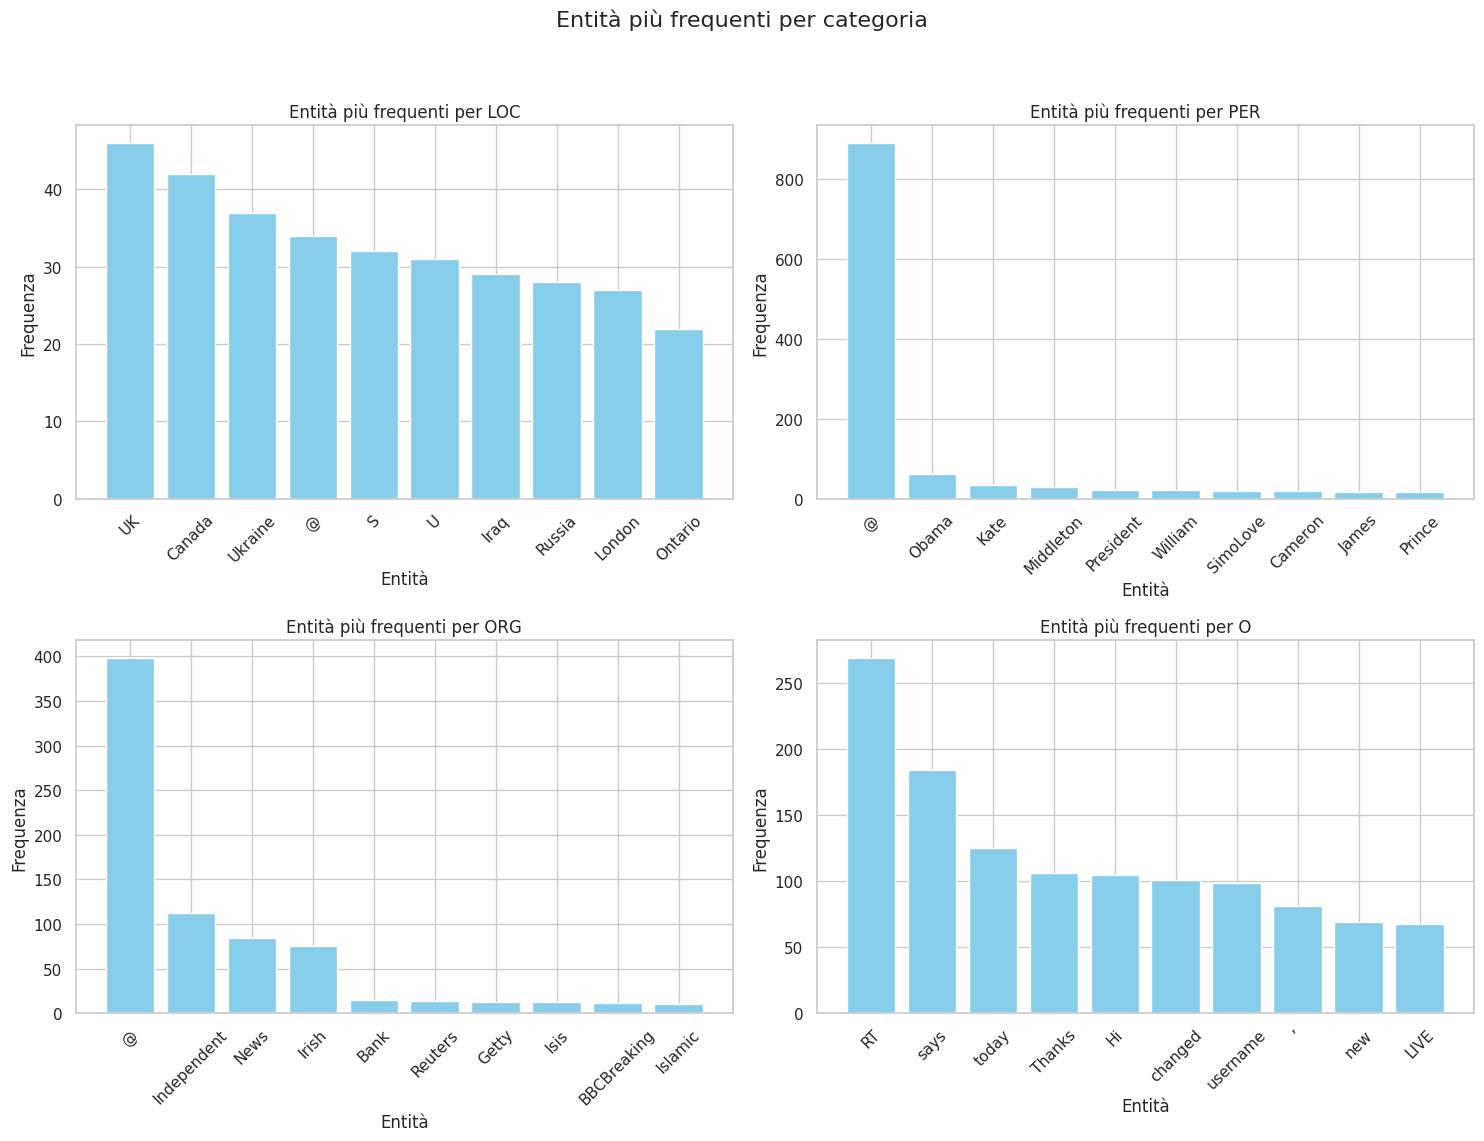

In [46]:
# Entità più frequenti per ogni categoria
def get_top_entities_by_label(data, label, top_n=10):
    # Filtrare i dati per la categoria specificata
    filtered_data = data[data['Label'] == label]
    # Contare i token all'interno della categoria
    entity_counts = Counter(filtered_data['token'])

    return entity_counts.most_common(top_n)


top_loc_entities = get_top_entities_by_label(combined_df, 'LOC')
top_per_entities = get_top_entities_by_label(combined_df, 'PER')
top_org_entities = get_top_entities_by_label(combined_df, 'ORG')
top_o_entities = get_top_entities_by_label(combined_df, 'O')


def plot_top_entities(ax, top_entities, label):
    entities, counts = zip(*top_entities)  # Separiamo entità e frequenze
    ax.bar(entities, counts, color='skyblue')
    ax.set_title(f"Entità più frequenti per {label}")
    ax.set_xlabel("Entità")
    ax.set_ylabel("Frequenza")
    ax.tick_params(axis='x', rotation=45)

# Creazione di un'unica figura con 4 grafici in 2x2
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Entità più frequenti per categoria', fontsize=16)

# Grafico per ciascuna categoria
plot_top_entities(axs[0, 0], top_loc_entities, 'LOC')
plot_top_entities(axs[0, 1], top_per_entities, 'PER')
plot_top_entities(axs[1, 0], top_org_entities, 'ORG')
plot_top_entities(axs[1, 1], top_o_entities, 'O')

# Adattare spazi per evitare sovrapposizioni
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Ogni grafico contiene le entità più frequenti (cioè le parole più comuni) in quella categoria, ordinate per frequenza.


Ad esempio:

Nel grafico di LOC si osservano termini geografici come UK, Canada, e Ukraine.

Nel grafico di PER compare Obama come entità più frequente, insieme ad altri nomi di persone.

Nel grafico di ORG si nota la presenza di termini come Independent e News, rappresentativi di organizzazioni.

Nel grafico di O, che contiene termini non classificati come entità, si trovano parole generiche come says, today, e LIVE.

---



3. **Distribuzione lunghezza frasi**


Il codice ha lo scopo di visualizzare la distribuzione delle lunghezze delle frasi nel training set, considerando come unità di misura il numero di token per frase. Utilizzo un istogramma per mostrare la frequenza delle diverse lunghezze di frase e sovrappongo una curva interpolata per rendere l'andamento più fluido e visivamente accattivante.

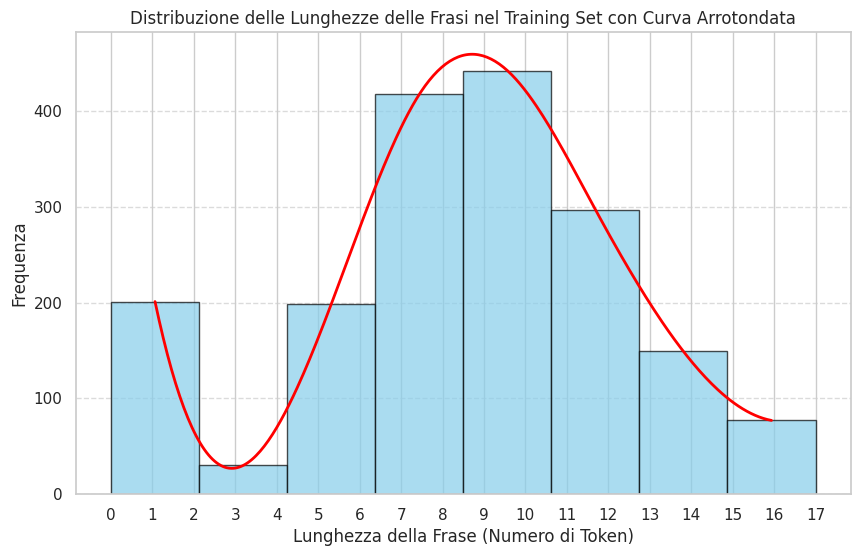

In [48]:
# Calcola la lunghezza di ciascuna frase contando i token per ogni Sentence_Num
sentence_lengths = combined_df.groupby('id').size()

# Visualizza la distribuzione delle lunghezze delle frasi con un istogramma
plt.figure(figsize=(10, 6))
plt.hist(sentence_lengths, bins=8, range=(0, 17), color='skyblue', edgecolor='black', alpha=0.7)

# Calcola i conteggi per ciascun bin e i centri dei bin
bin_counts, bin_edges = np.histogram(sentence_lengths, bins=8, range=(0, 17))
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])  # Centri dei bin

# Interpolazione spline per rendere la curva tondeggiante
xnew = np.linspace(bin_centers.min(), bin_centers.max(), 300)  # Genera più punti per una curva liscia
spl = make_interp_spline(bin_centers, bin_counts, k=3)  # k=3 per una spline cubica
y_smooth = spl(xnew)

# Aggiungi la curva interpolata al grafico
plt.plot(xnew, y_smooth, color='red', linewidth=2)

# Aggiungi titoli e etichette agli assi
plt.title("Distribuzione delle Lunghezze delle Frasi nel Training Set con Curva Arrotondata")
plt.xlabel("Lunghezza della Frase (Numero di Token)")
plt.ylabel("Frequenza")

# Etichette per l'asse X e griglia
plt.xticks(range(0, 18))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



---



4. **Distribuzione della lunghezza dei Token in base al NER Tag**


Questo codice ha l’obiettivo di confrontare la lunghezza media dei token (ad esempio, parole o simboli) per ciascuna etichetta (LOC, PER, ORG, O) e visualizzare la differenza tra le categorie.

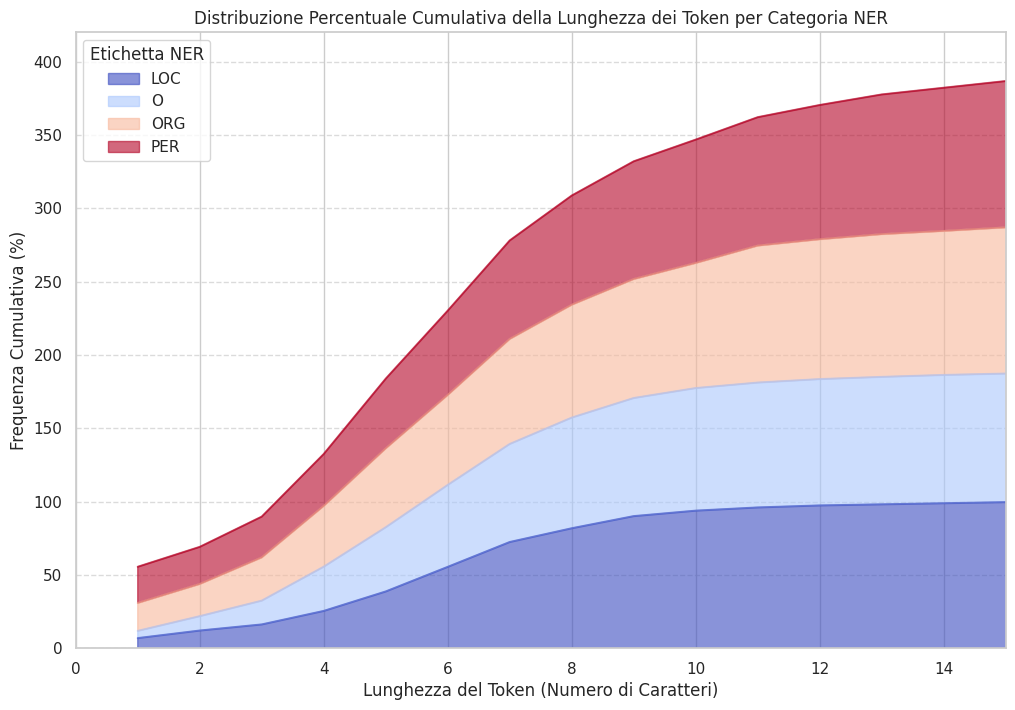

In [49]:
# Calcola la lunghezza di ciascun token in numero di caratteri
combined_df['token_length'] = combined_df['token'].apply(len)

# Calcola la distribuzione delle lunghezze dei token per ciascuna etichetta NER
token_length_distribution = combined_df.groupby(['token_length', 'Label']).size().unstack(fill_value=0)

# Calcola la distribuzione cumulativa per ciascuna etichetta NER in percentuale
token_length_distribution = token_length_distribution.cumsum()
token_length_distribution = (token_length_distribution / token_length_distribution.max()) * 100

# Creazione del grafico ad aree per la distribuzione delle lunghezze dei token
plt.figure(figsize=(12, 8))
token_length_distribution.plot(kind='area', stacked=True, alpha=0.6, colormap="coolwarm", ax=plt.gca())


plt.title("Distribuzione Percentuale Cumulativa della Lunghezza dei Token per Categoria NER")
plt.xlabel("Lunghezza del Token (Numero di Caratteri)")
plt.ylabel("Frequenza Cumulativa (%)")
plt.legend(title="Etichetta NER")
plt.grid(axis='y', linestyle='--', alpha=0.7)


plt.xlim(0, 15)  # Limitato a 15 caratteri, considerando la maggior parte dei token


plt.show()

Interpretazione delle Categorie:

PER (Rosso scuro): La categoria PER, che indica i nomi di persone, ha un aumento significativo tra i token con lunghezze da 3 a 8 caratteri. Questo suggerisce che i nomi propri tendono a essere relativamente corti, il che è coerente con la struttura dei nomi di persona più comuni.

ORG (Rosa): Gli enti o le organizzazioni hanno una distribuzione simile, ma leggermente più ampia rispetto a PER, indicando che i nomi di organizzazioni possono avere una maggiore variabilità in termini di lunghezza. Anche qui, i token sono concentrati prevalentemente nella fascia delle lunghezze più corte.

LOC (Blu): La categoria LOC, che rappresenta le entità geografiche, mostra una distribuzione più diluita, indicando che i nomi dei luoghi hanno una lunghezza dei token mediamente superiore rispetto a PER e ORG. Questo è atteso, poiché i nomi geografici spesso includono termini composti o più lunghi.

O (Azzurro chiaro): La categoria O, che contiene i token non classificati come entità riconosciute, è distribuita in modo più omogeneo e rappresenta la categoria con maggiore variabilità nella lunghezza dei token. Questo è prevedibile, dato che include una vasta gamma di parole comuni, non necessariamente entità, che possono variare molto in lunghezza.


---



5. **Coppie di Co-occorenze più comuni**

Il seguente codice serve a calcolare e visualizzare le co-occorrenze più comuni tra le parole nel dataset, cioè coppie di parole che appaiono spesso vicine l'una all'altra in una finestra di contesto specificata (qui impostata a 2 parole prima e dopo la parola corrente).

Le co-occorrenze possono fornire informazioni utili sui pattern di parole nel testo, come associazioni frequenti tra termini.

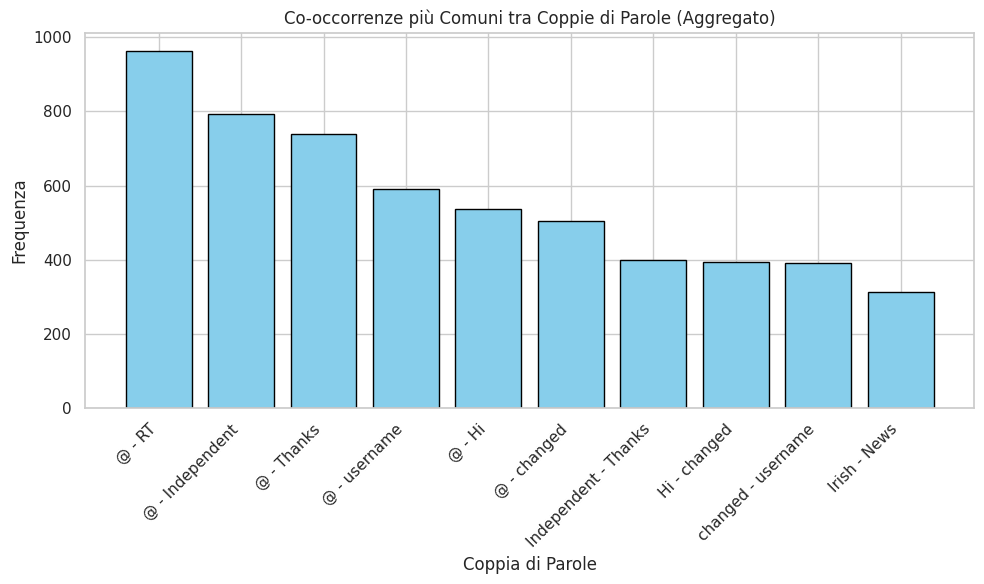

In [51]:
window_size = 2  # Numero di parole prima e dopo

# Funzione per calcolare e aggregare le co-occorrenze tra le parole
def get_aggregated_co_occurrences(data, window_size=2):
    co_occurrences = Counter()

    # Raggruppiamo i dati per 'Sentence_Num' per lavorare frase per frase
    for sentence_num, group in data.groupby('id'):
        tokens = group['token'].tolist()

        # Calcola le co-occorrenze all'interno della finestra di contesto
        for i in range(len(tokens)):
            context_window = tokens[max(0, i - window_size): min(len(tokens), i + window_size + 1)]
            for pair in combinations(context_window, 2):
                if pair[0] != pair[1]:  # Evita co-occorrenze della stessa parola con sé stessa
                    normalized_pair = tuple(sorted(pair))  # Ordina la coppia in ordine alfabetico
                    co_occurrences[normalized_pair] += 1   # Somma le frequenze delle coppie duplicate

    return co_occurrences

# Calcola e aggrega le co-occorrenze più comuni
aggregated_co_occurrences = get_aggregated_co_occurrences(combined_df, window_size=2)

# Ottieni le 10 co-occorrenze più comuni dopo l'aggregazione
top_aggregated_co_occurrences = aggregated_co_occurrences.most_common(10)
pairs, counts = zip(*top_aggregated_co_occurrences)

# Converti le coppie in stringhe per una visualizzazione più semplice
pair_labels = [f"{pair[0]} - {pair[1]}" for pair in pairs]

# Creazione del grafico a barre
plt.figure(figsize=(10, 6))
plt.bar(pair_labels, counts, color='skyblue', edgecolor='black')
plt.title("Co-occorrenze più Comuni tra Coppie di Parole (Aggregato)")
plt.xlabel("Coppia di Parole")
plt.ylabel("Frequenza")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()  # Aggiusta automaticamente il layout per evitare sovrapposizioni
plt.show()



L'output del grafico mostra le 10 co-occorrenze più comuni tra coppie di parole nel mio dataset, utilizzando una finestra di contesto di 2 parole. Ogni barra rappresenta una coppia di parole che appare frequentemente insieme nel testo, indipendentemente dall'ordine in cui si presentano.

Ad esempio:

@ - Independent: Questa è la coppia di parole più frequente, con oltre 700 occorrenze. Il simbolo @ in combinazione con "Independent" suggerisce un riferimento ricorrente a un account o una menzione specifica, probabilmente legata a una fonte informativa o un utente Twitter frequentemente citato nel dataset.


---



6. **WordCloud**

Questa Word Cloud personalizzata è stata creata utilizzando una maschera a forma di "PlotTwisters", permettendo di visualizzare le parole più frequenti nel dataset di training.

Ho caricato l'immagine per sagomare la Word Cloud e ho scelto di escludere le stopwords e alcuni termini irrilevanti (come "http", "RT", "t", ecc) per evitare rumore e rendere più leggibile il contenuto effettivo del testo.

Saving plottwisters_mask.png.png to plottwisters_mask.png.png


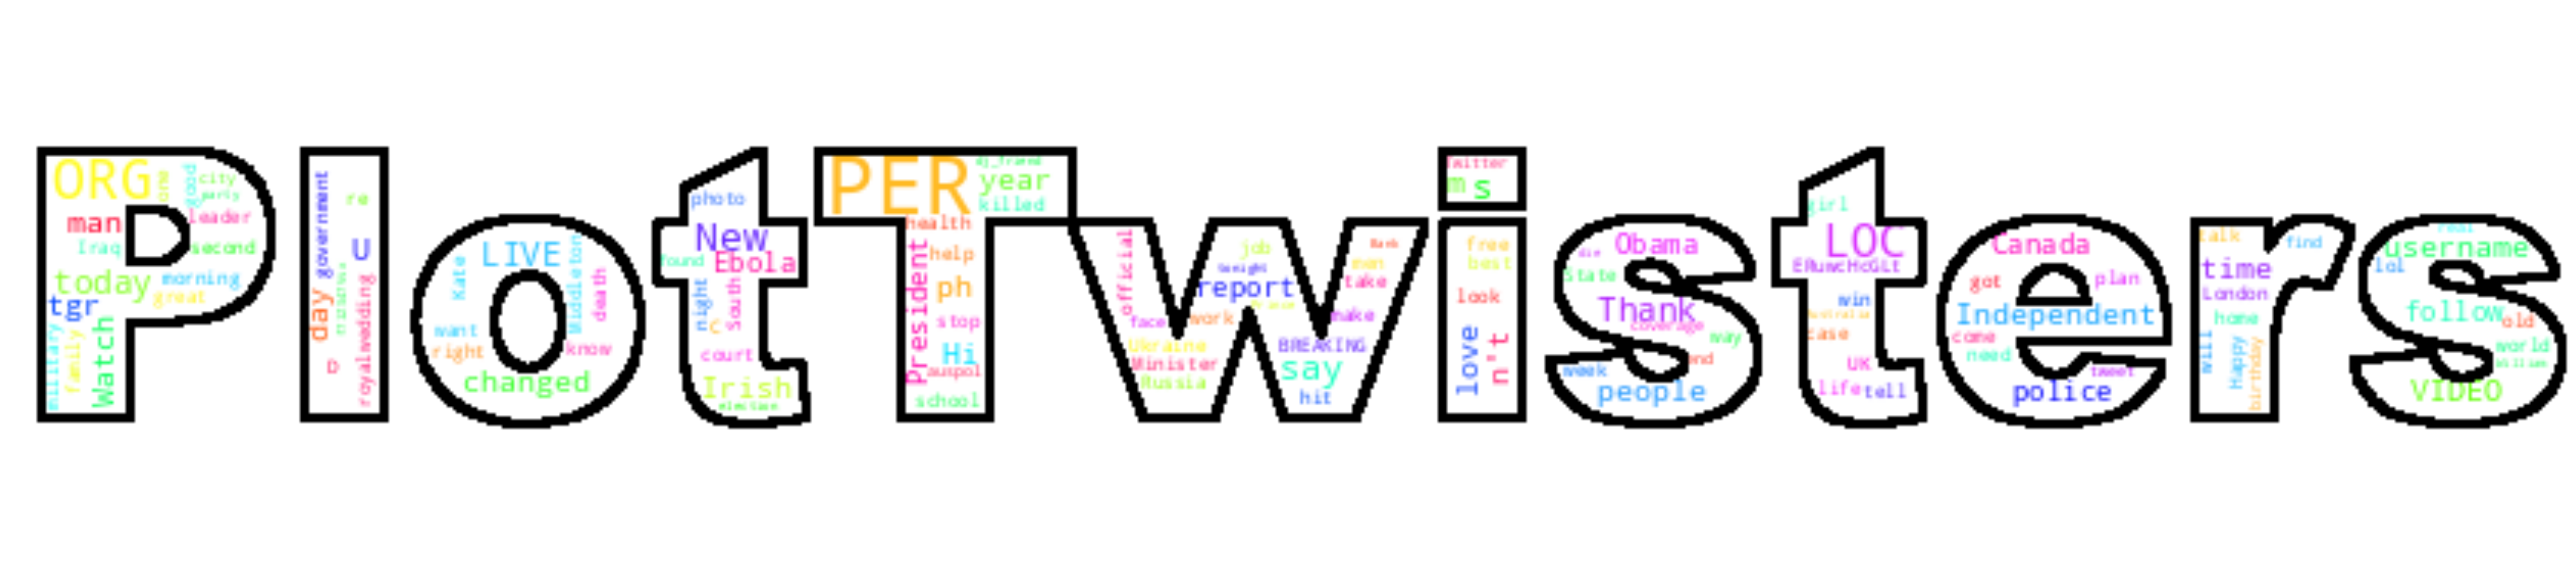

In [52]:
from google.colab import files

# Carica l'immagine della maschera dal computer
uploaded = files.upload()  # Questo aprirà una finestra per il caricamento del file
mask_image_path = next(iter(uploaded.keys()))  # Ottieni il nome del file caricato
mask_image = np.array(Image.open(mask_image_path))

# Prepara il testo unendo tutti i token del dataset di training
text = " ".join(combined_df['token'].astype(str))

# Definisci le stopwords
stopwords = set(STOPWORDS)
stopwords.update(['DOCSTART', 'http', 'https', 't', 'co', 'RT','O', 'B' ])  # Aggiungi ulteriori parole se necessario

# Funzione di colore personalizzata per colori vivaci e saturi
def vibrant_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    h = int(360.0 * random.random())  # Colori casuali
    s = 100  # Saturazione massima
    l = 50 + random.random() * 10  # Luminosità media
    return f"hsl({h}, {s}%, {l}%)"

# Crea e genera la Word Cloud con contorni più marcati e colori più vivaci
wordcloud = WordCloud(
    width=mask_image.shape[1] * 2,  # Aumenta la risoluzione
    height=mask_image.shape[0] * 2,  # Aumenta la risoluzione
    background_color='white',
    mask=mask_image,
    stopwords=stopwords,
    max_words=300,  # Riduci il numero massimo di parole
    max_font_size=300,  # Aumenta la dimensione massima del font per ingrandire le parole
    contour_width=4,  # Contorno più marcato
    contour_color='black',
    random_state=42,
    collocations=False  # Evita duplicati di parole
).generate(text)

# Visualizza la Word Cloud con la funzione di colore personalizzata
plt.figure(figsize=(40, 20))  # Aumenta ulteriormente le dimensioni della figura per migliorare la risoluzione
plt.imshow(wordcloud.recolor(color_func=vibrant_color_func), interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

# Salva l'immagine in un file (opzionale)
wordcloud.to_file('plottwisters_wordcloud_vibrant.png')


Nell'output si vedono parole come "Independent", "Today", "Thanks", e "@username" che appaiono più grandi, indicando una maggiore frequenza nel testo. I colori vivaci e i contorni neri marcati fanno risaltare le parole, rendendo immediata l’identificazione dei termini più importanti. Le dimensioni delle parole riflettono la loro frequenza nel dataset, quindi le parole più grandi sono quelle più ricorrenti.

---



7. **Matrice delle co-occorrenze tra le Etichette NER**


In questo codice,  abbiamo calcolato una matrice di co-occorrenza delle etichette NER per vedere con quale frequenza le diverse categorie di entità appaiono insieme nelle stesse fras

Etichette trovate nella colonna 'Label': ['O' 'ORG' 'PER' 'LOC']


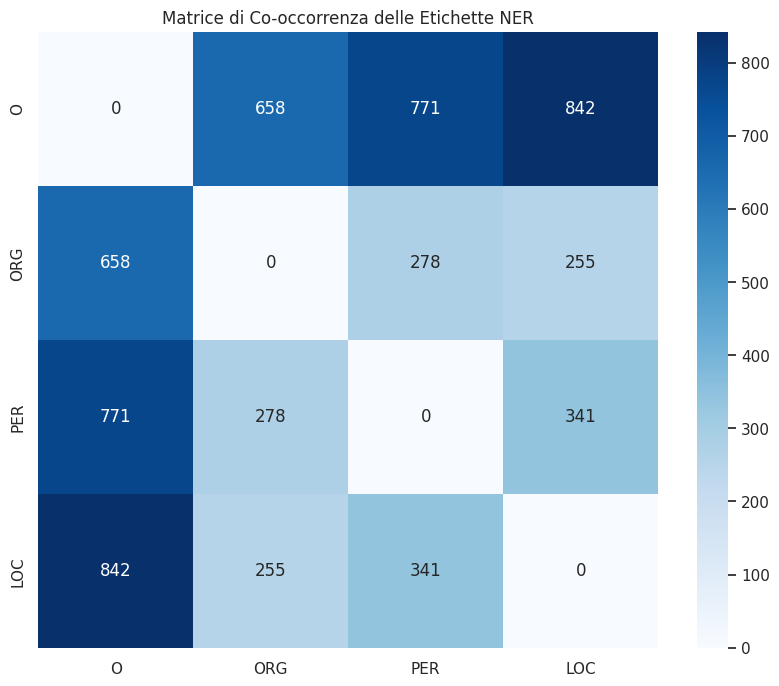

In [53]:
# Estrai i valori unici dalla colonna 'Label' per garantire che tutte le etichette siano incluse
unique_labels = combined_df['Label'].unique()
print("Etichette trovate nella colonna 'Label':", unique_labels)

# Raggruppiamo per 'Sentence_Num' e raccogliamo tutte le etichette presenti in ciascuna frase
ner_per_sentence = combined_df.groupby('id')['Label'].apply(lambda x: list(set(x))).reset_index()

# Inizializza una matrice di co-occorrenza con zero per ciascuna coppia di etichette
co_occurrence_matrix = pd.DataFrame(0, index=unique_labels, columns=unique_labels)

# Compila la matrice di co-occorrenza
for labels in ner_per_sentence['Label']:
    for label1 in labels:
        for label2 in labels:
            if label1 != label2:  # Evita di contare una coppia della stessa etichetta
                co_occurrence_matrix.loc[label1, label2] += 1

# Visualizza la matrice di co-occorrenza
plt.figure(figsize=(10, 8))
sns.heatmap(co_occurrence_matrix, annot=True, cmap='Blues', fmt="d")
plt.title("Matrice di Co-occorrenza delle Etichette NER")
plt.show()

---


8. **Distribuzione delle Parti del Discorso (POS Tags)**

Questo codice ha lo scopo di analizzare la distribuzione dei POS (Part-of-Speech) tags presenti nei token del dataset di training. Utilizzando il modello linguistico di spaCy, il codice assegna a ciascun token un'etichetta POS, che indica la sua funzione grammaticale (come sostantivo, verbo, aggettivo, ecc.).

Visualizzare questa distribuzione mi permette di capire quali tipi di parole sono più comuni nel testo e di ottenere un quadro generale della struttura linguistica del dataset.

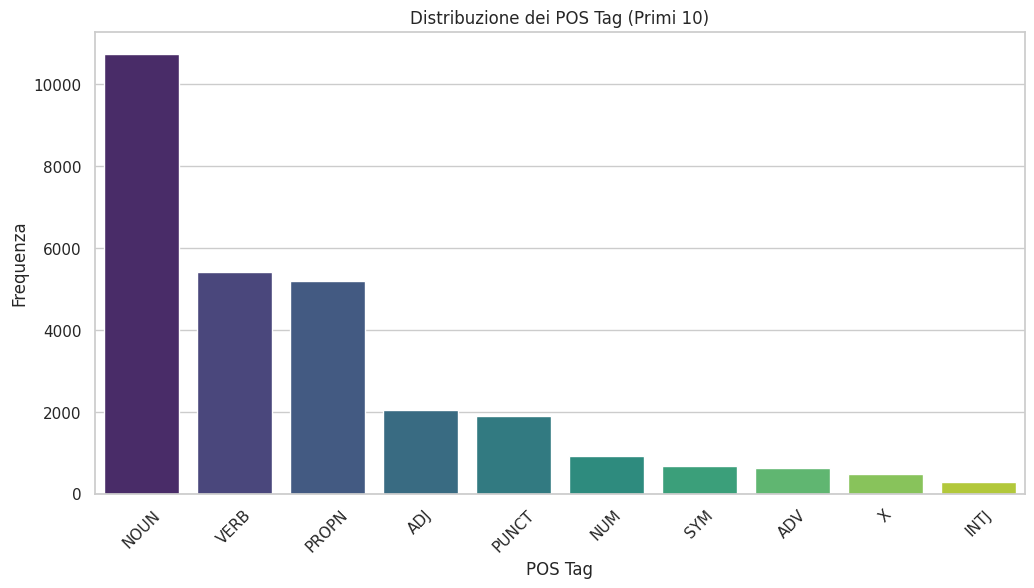

In [55]:
# Carica il modello di spaCy e disattiva componenti inutili per velocizzare il processo
nlp = spacy.load('en_core_web_sm', disable=["ner", "parser"])

# Funzione per ottenere i POS tag per ogni token in modalità batch
def get_pos_tags_in_batch(tokens):
    # Concatena tutti i token in un unico documento spaCy
    docs = list(nlp.pipe(tokens, batch_size=1000))  # Usa la pipe per processare in batch.
                                                    # nlp.pipe permette di processare i token in batch.
                                                    # Specificando un batch_size (in questo esempio, 1000), spaCy elabora i dati in blocchi, migliorando le prestazioni.
    # Estrai solo il POS tag del primo token di ogni doc
    pos_tags = [doc[0].pos_ if len(doc) > 0 else 'X' for doc in docs]
    return pos_tags

# Applica la funzione a tutti i token del dataset in modalità batch
combined_df['pos_tag'] = get_pos_tags_in_batch(combined_df['token'].tolist()) # get_pos_tags_in_batch: Questa funzione elabora i token in batch e restituisce solo il POS tag di ciascun token, riducendo il tempo di calcolo.

# Calcola la distribuzione dei POS tag
pos_counts = combined_df['pos_tag'].value_counts()

# Limita la distribuzione ai primi 10 POS tag
top_10_pos_counts = pos_counts.head(10)

# Visualizza la distribuzione dei primi 10 POS tag con un grafico a barre
plt.figure(figsize=(12, 6))
sns.barplot(x=top_10_pos_counts.index, y=top_10_pos_counts.values, palette="viridis")
plt.title("Distribuzione dei POS Tag (Primi 10)")
plt.xlabel("POS Tag")
plt.ylabel("Frequenza")
plt.xticks(rotation=45)
plt.show()



---











9. **Analisi di Sentiment**

Nel segeunte modello di sentiment analisi trasformer utilizza *DistilBERT Fine-Tuned su SST-2* . Questo modello è stato addestrato sul Stanford Sentiment Treebank (SST-2), un dataset composto principalmente da recensioni cinematografiche. Di conseguenza, il modello è ottimizzato per riconoscere sentimenti positivi e negativi in quel contesto specifico.

Classi di Sentiment: Questo modello restituisce due classi, POSITIVE e NEGATIVE, quindi è progettato per sentiment binario.

Architettura: DistilBERT è una versione ottimizzata e più leggera del modello BERT, sviluppata per essere più veloce e meno dispendiosa in termini di memoria, mantenendo al contempo un'accuratezza elevata.



No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

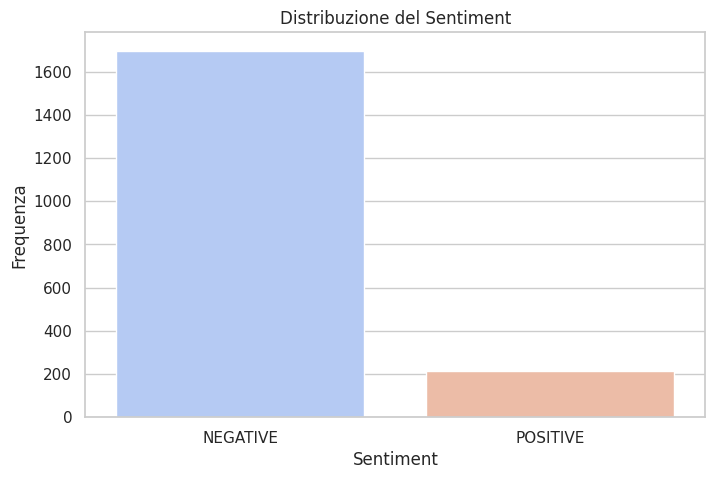

In [56]:
# Inizializza il pipeline di sentiment analysis
sentiment_analyzer = pipeline("sentiment-analysis")

# Funzione per troncare le frasi a 512 caratteri
def truncate_text(text, max_length=512):
    return text[:max_length]

# Raggruppa i token per frase e crea un testo completo per ciascuna frase
sentences = combined_df.groupby('id')['token'].apply(lambda x: ' '.join(x)).tolist()

# Applica la troncatura a tutte le frasi
sentences = [truncate_text(sentence) for sentence in sentences]

# Funzione per eseguire il sentiment analysis in batch
def get_batch_sentiment(sentences, batch_size=100):
    sentiments = []
    for i in range(0, len(sentences), batch_size):
        batch = sentences[i:i + batch_size]
        results = sentiment_analyzer(batch)
        sentiments.extend([res['label'] for res in results])  # Estrai solo la label del sentiment
    return sentiments

# Applica il sentiment analysis in batch su tutte le frasi
sentiments = get_batch_sentiment(sentences)

# Crea un DataFrame con i risultati del sentiment per ciascuna frase
sentiment_df = pd.DataFrame({'id': range(len(sentiments)), 'sentiment': sentiments})

# Conta la distribuzione dei sentiment
sentiment_counts = sentiment_df['sentiment'].value_counts()

# Visualizza la distribuzione dei sentiment con un grafico a barre
plt.figure(figsize=(8, 5))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="coolwarm")
plt.title("Distribuzione del Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Frequenza")
plt.show()

Questo secondo modello utilizza *Twitter RoBERTa base* che è stato specificatamente addestrato su dati provenienti da Twitter, più adatto quindi al nostro dataset.

Classi di Sentiment: Questo modello restituisce tre classi, POSITIVE, NEUTRAL, e NEGATIVE, il che lo rende più adatto a rappresentare la complessità del linguaggio dei social media.

Architettura: Basato su RoBERTa, un modello robusto e ottimizzato per il natural language processing, che offre un’alta accuratezza.

Limiti:essendo stato addestrato su Twitter, potrebbe riflettere bias presenti nei dati originali. Inoltre Come molti modelli basati su RoBERTa, Twitter RoBERTa base ha un limite di 512 token. Sebbene i tweet siano generalmente brevi, alcuni tweet con molte menzioni o hashtag potrebbero superare questo limite.

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

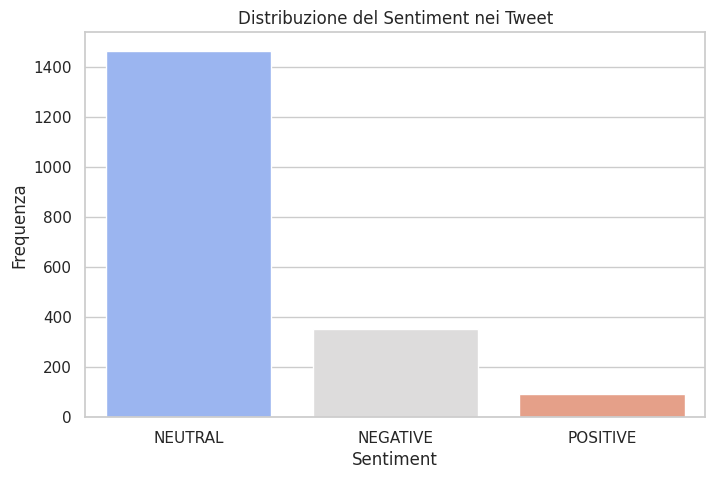

In [57]:
# Inizializza il pipeline di sentiment analysis con il modello specifico per Twitter
sentiment_analyzer = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")

# Funzione per troncare le frasi a 512 caratteri
def truncate_text(text, max_length=512):
    return text[:max_length]

# Raggruppa i token per frase e crea un testo completo per ciascuna frase
sentences = combined_df.groupby('id')['token'].apply(lambda x: ' '.join(x)).tolist()

# Applica la troncatura a tutte le frasi
sentences = [truncate_text(sentence) for sentence in sentences]

# Funzione per eseguire il sentiment analysis in batch con etichette interpretate
def get_batch_sentiment(sentences, batch_size=50):
    sentiments = []
    for i in range(0, len(sentences), batch_size):
        batch = sentences[i:i + batch_size]
        results = sentiment_analyzer(batch)
        # Mappa le etichette numeriche ai nomi dei sentiment
        sentiments.extend([{'LABEL_0': 'NEGATIVE', 'LABEL_1': 'NEUTRAL', 'LABEL_2': 'POSITIVE'}[res['label']] for res in results])
    return sentiments

# Applica il sentiment analysis in batch su tutte le frasi
sentiments = get_batch_sentiment(sentences)

# Crea un DataFrame con i risultati del sentiment per ciascuna frase
sentiment_df = pd.DataFrame({'id': range(len(sentiments)), 'sentiment': sentiments})

# Conta la distribuzione dei sentiment
sentiment_counts = sentiment_df['sentiment'].value_counts()

# Visualizza la distribuzione dei sentiment con un grafico a barre
plt.figure(figsize=(8, 5))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="coolwarm")
plt.title("Distribuzione del Sentiment nei Tweet")
plt.xlabel("Sentiment")
plt.ylabel("Frequenza")
plt.show()